## General ZAF MODEL:
for Al2O3 there is no MAC for the Al-O for La and Lb so Ll is used!!!


In [1]:
import math
import pandas as pd
import numpy as np
import sqlite3

# import MAC
# mac_df = pd.read_csv("Henke 1993_modified.txt")
mac_df = pd.read_csv("Henke 1993_modified_added_Al_O_from_paper.txt")
# !inputs: concentrations, take off angle and accelerating voltage
elements = ['Al','O']
#LiNbO3 Molar mass = 6.941+92.9+3*15.999 = 147.838
C = {'Al':0.5292,'O': 0.4707}
Ec = {'Al':0.07295,'O': 0.5431} ### Check if you have to add all the lines and what to put for H
A = {'Al':26.982,'O': 15.999}
Z = {'Al':13,'O': 8}
# xray database
con = sqlite3.connect('xraydb.sqlite')
cur = con.cursor()
query = """
SELECT * FROM xray_transitions WHERE """

## Experimental conditions
take_off_angle = 40
E0 = 5 # keV

# for the emission of 
emission = {'element':'Al', 'line':'La'}

# calculating X for each element
print("[+] The program is considering the emission of ", emission['element'], emission['line'])
# Extracting the needed MAC from the Henke database
sample_mac = pd.DataFrame()
for idx, value in enumerate(elements):
    new_row = pd.DataFrame({'abs': [value], 'mac': [mac_df[(mac_df['zAbs'] == value) & (mac_df['zMes'] == emission['element'])][emission['line']].values[0]] })
    print(new_row)
    sample_mac = sample_mac.append(new_row, ignore_index=True)
print(sample_mac)
print(mac_df)

[+] The program is considering the emission of  Al La
  abs    mac
0  Al  10400
  abs     mac
0   O  120000
  abs     mac
0  Al   10400
1   O  120000
     zAbs zMes     Ka  Kb   La   Lb   Ll   Ma   Mb  Mz
0       H    H      0   0    0    0    0    0    0 NaN
1       H   He      0   0    0    0    0    0    0 NaN
2       H   Li  10734   0    0    0    0    0    0 NaN
3       H   Be    970   0    0    0    0    0    0 NaN
4       H    B    161   0    0    0    0    0    0 NaN
...   ...  ...    ...  ..  ...  ...  ...  ...  ...  ..
8459    U   Ra      0   0  118   67  175  864  775 NaN
8460    U   Ac      0   0  110   61  164  802  719 NaN
8461    U   Th      0   0  100   55  151  734  657 NaN
8462    U   Pa      0   0   94   51  143  689  615 NaN
8463    U    U      0   0   86  109  131  629  550 NaN

[8464 rows x 10 columns]


C:\Users\khalil\AppData\Local\Temp\ipykernel_34764\886537826.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_mac = sample_mac.append(new_row, ignore_index=True)
C:\Users\khalil\AppData\Local\Temp\ipykernel_34764\886537826.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_mac = sample_mac.append(new_row, ignore_index=True)


In [2]:
############### Ai absorption general ############### 
# Calculating the X & sigma & h
# X
X = pd.DataFrame()
X_tot = 0
# sigma
sigma = pd.DataFrame()
sigma_tot = 0
# h
h = pd.DataFrame()
h_tot = 0
for idx, value in enumerate(elements):
    # calculating X
    new_row = pd.DataFrame({'element': [value], 'X': sample_mac[sample_mac['abs'] == value]['mac'].values[0] * (1/math.sin(math.radians(take_off_angle)))})
    X = X.append(new_row, ignore_index=True)
    # calculating X total
    X_tot = X_tot + C[value] * sample_mac[sample_mac['abs'] == value]['mac'].values[0] * (1/math.sin(math.radians(take_off_angle)))
    # Calculating sigma
    new_row = pd.DataFrame({'element': [value], 'sigma': (4.5*pow(10,5))/(pow(E0, 1.65)-pow(Ec[value], 1.65))})
    sigma = sigma.append(new_row, ignore_index=True)
    # calculating sigma total - The parameter sigma is a factor which accounts for the voltage dependence of the absorption or loss of the primary electrons.
    sigma_tot = sigma_tot + C[value] * (4.5*pow(10,5))/(pow(E0, 1.65)-pow(Ec[value], 1.65))
    # calculating h; h = 1.2 * A/Z^2
    new_row = pd.DataFrame({'element': [value], 'h': 1.2 * A[value]/pow(Z[value],2)}) 
    h = h.append(new_row, ignore_index=True)
    # calculating h total
    h_tot = h_tot + C[value] * 1.2 * A[value]/pow(Z[value],2)
# calculating the 1/f(X)
reverse_f_X = (1 + X_tot/sigma_tot)*(1 + (h_tot/(1+h_tot))*X_tot/sigma_tot)
print("Absorption correction factor for",emission['element'] , emission['line'], reverse_f_X)

Absorption correction factor for Al La 6.37037030510947


C:\Users\khalil\AppData\Local\Temp\ipykernel_34764\3266418479.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(new_row, ignore_index=True)
C:\Users\khalil\AppData\Local\Temp\ipykernel_34764\3266418479.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sigma = sigma.append(new_row, ignore_index=True)
C:\Users\khalil\AppData\Local\Temp\ipykernel_34764\3266418479.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  h = h.append(new_row, ignore_index=True)


In [3]:
#### Fluorescence F ####
# correction negligible if (E-Ec) > 5keV
# The mean depth of production of fluorescence radiation is greater than that of primary radiation (electrons)
# The correction factor Ifij/Ii relates the intensity of radiation of element i produced by fluorescence by element j, Ifij, 
# to the electron-generated intensity of radiation from element i, Ii;.
# REED (1965)
# absorption jump ratio
"""
    @input: list of elements causing the parasitic fluorescence "Fluorescer"
"""
# Test data
# to remove!!!!!
# C = {'Ni': 0.9, 'Fe': 0.1}
# emission = {'element':'Fe', 'line':'Ka'}
# End test data
# inputs 

fluorescers = ['O']
fluo_line = ['Ka']
fluo_yield = {'O':0.0058}
# Pij factor for the type of fluorescence occuring, if KK ( a K line fluoresces a K line) or LL fluorescence occurs Pij=1; KL or LK Pij = 4.76 for LK and 0.24 for KL
Pij = 1
# (r_i - 1)/r_i = 0.88 for K line and equal 0.75 for L line 
abs_jump_ratio = {'K':0.88, 'L': 0.75}
# Y_0 = 0.5 * ((r_i - 1)/r_i) * w_j * (A_i/A_j)
## Fe
"""
    abs_jump_ration @input
"""
# is the mass absorption coefficient of the specimen for radiation from element i,
# i emitter, j absorber
mac_sample_i = 0
for idx2,value2 in enumerate(elements):
    mac_sample_i = mac_sample_i + C[value2] * mac_df[(mac_df['zAbs'] == value2) & (mac_df['zMes'] == emission['element'])][emission['line']].values[0]

Ifij_by_Ii = 0
for idx, value in enumerate(fluorescers):
    # abs_jump_ratio used for K line since we are interested by the K line of the element
    Y_0 = 0.5 * (abs_jump_ratio['K'] * fluo_yield[value] * (A[emission['element']]/A[value]))
    if value == 'Al':
        Y_0 = 0.5 * (abs_jump_ratio['L'] * fluo_yield[value] * (A[emission['element']]/A[value]))
    print("Y_0: ",value ,Y_0)
    Ui = E0/Ec[emission['element']]
    Uj = E0/Ec[value]
    Y_1 = pow(((Uj - 1)/(Ui - 1)), 1.67)
    print("Y_1: ",value ,Y_1)
    # mac_ij is the mass absorption coefficient of element i for radiation from element j
    # mac_j_spec is the mass absorption coefficient of the specimen for radiation from element j
    # is the mass absorption coefficient of the specimen for radiation from element j.
    mac_sample_j = 0
    for idx2,value2 in enumerate(elements):
        mac_sample_j = mac_sample_j + C[value2] * mac_df[(mac_df['zAbs'] == value2) & (mac_df['zMes'] == value)][fluo_line[idx]].values[0]
    print("mac_sample_j: ", value ,mac_sample_j)
    Y_2 = mac_df[(mac_df['zAbs'] == emission['element']) & (mac_df['zMes'] == value)][fluo_line[idx]].values[0]
    Y_2 = Y_2/mac_sample_j
    print("Y_2: ",value ,Y_2)
    # Y3 account for absorption
    u = ((mac_sample_i)/(mac_sample_j)) * (1/math.sin(math.radians(take_off_angle)))
    
    # Ec is evaluated for element i
    v = (3.3 * pow(10,5))/((pow(E0,1.65) - pow(Ec[emission['element']],1.65))*(mac_sample_j))

    Y_3 = (math.log(1 + u)/u) + (math.log(1+v)/v)
    print("Y_3: ",value ,Y_3)
    # in case the standard is a pure element
    Ifij_by_Ii = Ifij_by_Ii + C[value]*Y_0*Y_1*Y_2*Y_3*Pij
Fi = 1/(1 + Ifij_by_Ii)
print("E0, take off angle,", E0,",",take_off_angle)
print("If_Fe_Ni/I_Fe, ", Ifij_by_Ii)
print("Emitting element", emission['element'], emission['line'], 'studied,', 'Fluorescers: ', fluo_line,', Fi Correction:', Fi)

Y_0:  O 0.004303897993624601
Y_1:  O 0.02959836087694094
mac_sample_j:  O 6557.5008
Y_2:  O 1.7268774103695115
Y_3:  O 0.614710711500382
E0, take off angle, 5 , 40
If_Fe_Ni/I_Fe,  6.365113002017646e-05
Emitting element Al La studied, Fluorescers:  ['Ka'] , Fi Correction: 0.9999363529211882


## Z correction:

In [4]:

#### Atomic Number Factor Z ####
# The so-called atomic number effect in electron microprobe analysis arises from two phenomena, namely, electron backscattering and electron retardation.
# both of which depend upon the average atomic number of the target.
# ! this correction is needed if there is a difference between the average atomic number of the specimen and that of the standard
# “light elements in a heavy matrix usually yield values which are too high.” ([Goldstein et al., 1981, p. 317])

# calculating the average Z of the sample
avg_z_spec = 0
for idx, value in enumerate(elements):
    avg_z_spec = avg_z_spec + C[value] * Z[value]
print('Average atomic number of the specimen: ',avg_z_spec)
############################## for Cu Ka ############################## 
## R backscattering correction factors range from 0.5-1 (close to 1 at low atomic numbers) 
# varies with Z and overvoltage U = Eo/Ec (as decreases towards 1 few electrons are backscattered
R = np.zeros((len(elements),len(elements)))
Ri = np.zeros((len(elements),))
for idx1, value1 in enumerate(elements):
    for idx2, value2 in enumerate(elements):
        print(value1, value2)
        U = E0/Ec[value1]
        R1 = 8.73 * 0.001 * pow(U,3) - 0.1669 * pow(U,2) + 0.9662 * U + 0.4523
        R2 = 2.703 * 0.001 * pow(U,3) - 5.182 * 0.01 * pow(U,2) + 0.302*U -0.1836
        R3 = (0.887 * pow(U,3) - 3.44 * U * U + 9.33 * U - 6.43)/pow(U,3)
        R[idx1][idx2]= R1 - R2 * math.log(R3*Z[value2] + 25)
        Ri[idx1] = Ri[idx1] + C[value2] * R[idx1][idx2]
# index is the emitting element
Rij_df = pd.DataFrame(R, columns=elements, index=elements)
Ri = pd.DataFrame(Ri, columns=['R'], index=elements)
print("\n## Rij for the specimen:")
print(Rij_df)
print("\n## Ri for the specimen:")
print(Ri)

# Ri = sum(j) CjRij
# Ri = C[0] * Rij
# # mean ionization potential J = 9.76 * Z + 58.8 * pow(Z, -0.19) [eV] # Berger and Seltzer (1964) !!!! problems with Z < 11, by lot of authors
J = pd.DataFrame()
for idx,value in enumerate(elements):
    new_row = pd.DataFrame({'element': [value], 'J': 9.76 * Z[value] + 58.8 * pow(Z[value], -0.19)})
    J = J.append(new_row, ignore_index=True)
print("\n## J for the specimen:")
print("J, ", J)
# # S is the electron stopping power 
# # “i represents the element i which is measured and j represents each of the elements present in the standard or specimen including element i.” ([Goldstein et al., 1981, p. 319]
S = np.zeros((len(elements),len(elements)))
Si = np.zeros((len(elements),))
for idx1, value1 in enumerate(elements):
    for idx2, value2 in enumerate(elements):
        S[idx1][idx2]= (Z[value1] / (A[value1]*(E0 + Ec[value2]))) * math.log(583*(E0+Ec[value2])/J[J['element'] == value2]['J'].values[0])
        Si[idx1] = Si[idx1] + C[value2] * S[idx1][idx2]
# index is the emitting element
S = pd.DataFrame(S, columns=elements, index=elements)
Si = pd.DataFrame(Si, columns=['S'], index=elements)
print("\n## S for the specimen:")
print("S", S)
print("\n## Si for the specimen:")
print("Si", Si)

## For the standard
# Using of element Cu
print("\n## For the standard Li:")
Si_std = (Z["Al"] / (A["Al"]*(E0 + Ec["Al"]))) * math.log(583*(E0+Ec["Al"])/J[J["element"] =="Al"]["J"].values[0])
print("Si standard, ", Si_std)
# R Standard
U = E0/Ec["Al"]
R1 = 8.73 * 0.001 * pow(U,3) - 0.1669 * pow(U,2) + 0.9662 * U + 0.4523
R2 = 2.703 * 0.001 * pow(U,3) - 5.182 * 0.01 * pow(U,2) + 0.302*U -0.1836
R3 = (0.887 * pow(U,3) - 3.44 * U * U + 9.33 * U - 6.43)/pow(U,3)
Ri_std = R1 - R2 * math.log(R3*Z["Al"] + 25)
print("Ri standard, ", Ri_std)
Z_Li = (Ri.iloc[0].values/Ri_std)*(Si_std/Si.iloc[0].values)
# print("Ri Li", Ri.iloc[0])
# print("Si Li", Si.iloc[0])
print('\n')
print("Z correction:", Z_Li[0])
print("A correction:", reverse_f_X)
print("F correction:", Fi)
ki = C['Al'] / Z_Li[0] * reverse_f_X * Fi
I_std = 160000
Ii = ki * I_std
print("Intensity of Al2O3: ", Ii)
###"""
# As discussed earlier unless the atomic number effect is corrected for, 
# analyses of heavy elements in a light element matrix (Cu in AI) generally 
# yield values which are too low (Zj > I) while analyses of light elements 
# in a heavy matrix (AI in Cu) usually yield values which are too high (Zj < I).
#"""

Average atomic number of the specimen:  10.645199999999999
Al Al
Al O
O Al
O O

## Rij for the specimen:
            Al           O
Al -224.704616 -144.289302
O     0.916505    0.947209

## Ri for the specimen:
             R
Al -186.830657
O     0.930866

## J for the specimen:
J,    element           J
0      Al  162.998366
1       O  117.688667

## S for the specimen:
S           Al         O
Al  0.275272  0.287938
O   0.285687  0.298831

## Si for the specimen:
Si            S
Al  0.281206
O   0.291845

## For the standard Li:
Si standard,  0.27527222022552683
Ri standard,  -224.70461609627864


Z correction: 0.8139045933236888
A correction: 6.37037030510947
F correction: 0.9999363529211882
Intensity of Al2O3:  662679.2233066369


C:\Users\khalil\AppData\Local\Temp\ipykernel_34764\1359633222.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  J = J.append(new_row, ignore_index=True)


# Figure for the EPMA paper

3.8.1


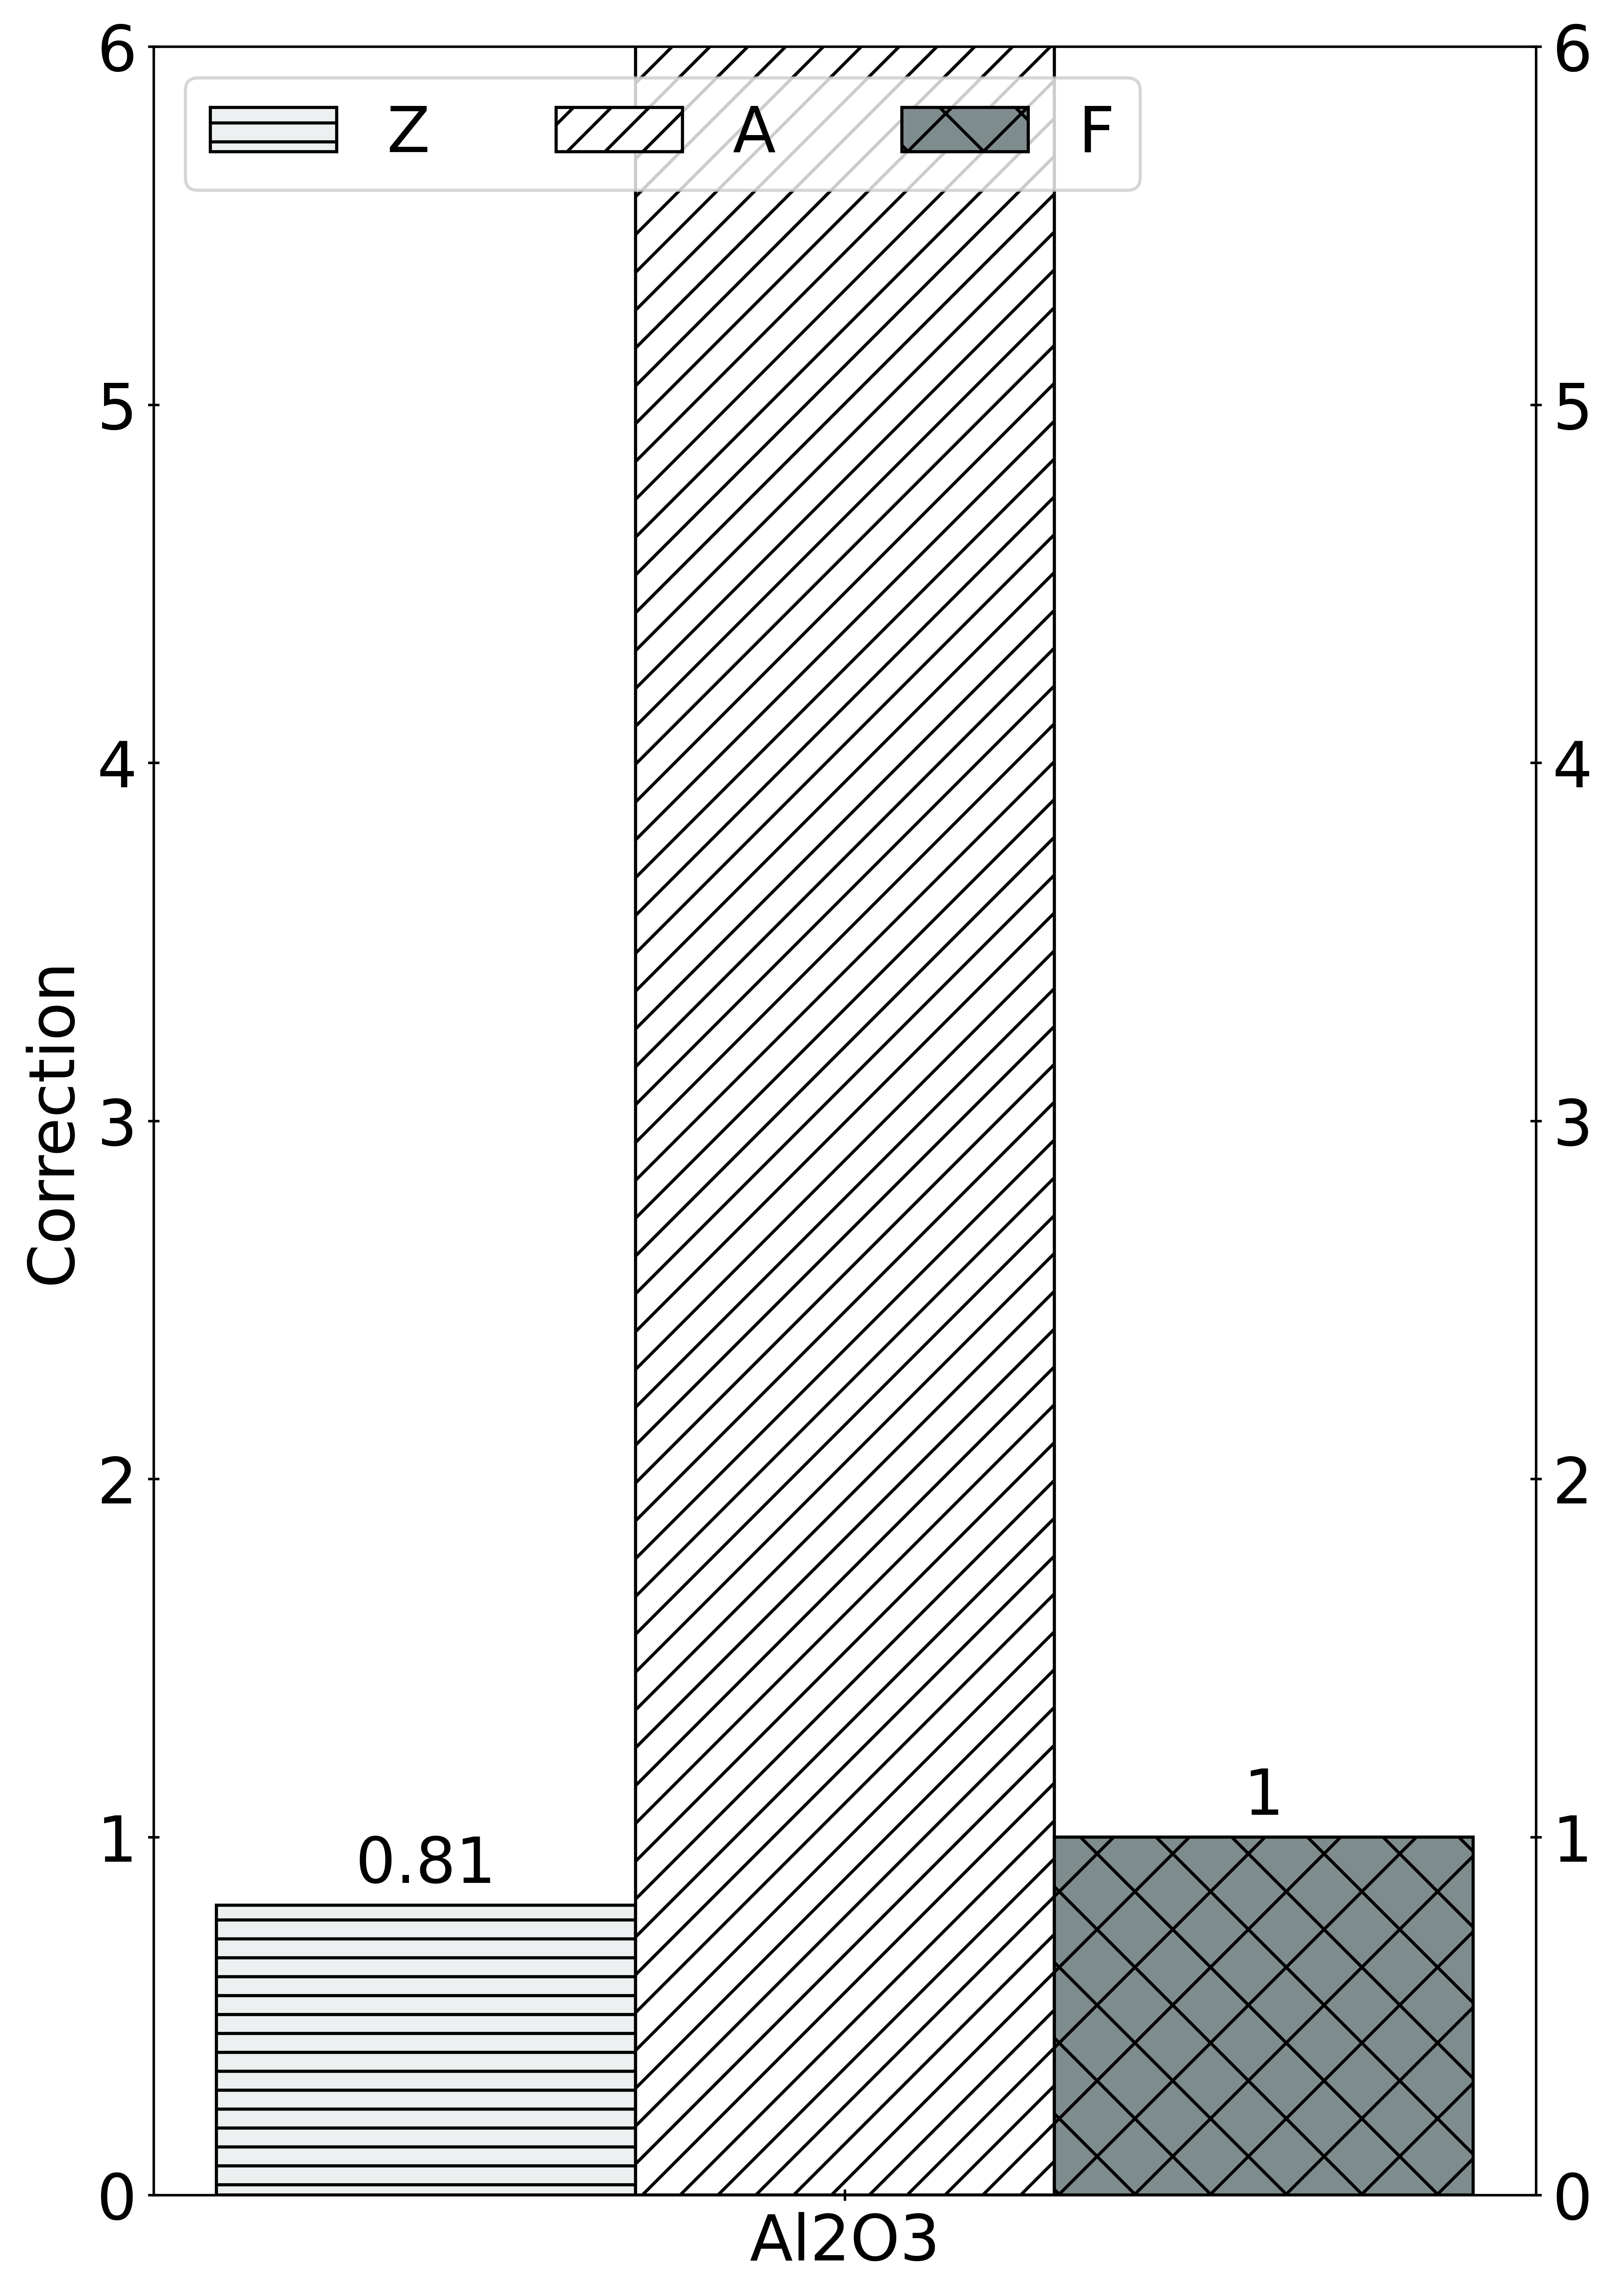

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
print(matplotlib.__version__)
font = {'size'   : 20, 'weight':'light'}
matplotlib.rc('font', **font)
species = ["Al2O3"]
penguin_means = {
    'Z': (float('{:.2f}'.format(Z_Li[0]))),
    'A': (float('{:.2f}'.format(reverse_f_X))),
    'F': (float('{:.2f}'.format(Fi))),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(7,10), dpi=600)
plt.tick_params(labelright=True)
ax.tick_params(which='both', direction='inout', right=True, top=False)
colors_list = ['#ecf0f1','#fff','#7f8c8d']
hatches = ['--','//','x']
i = 0
for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width,edgecolor='black',label=attribute, color=colors_list[i], hatch=hatches[i])
    ax.bar_label(rects, padding=3)
    multiplier += 1
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correction')
ax.set_title('')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 6)

plt.show()

In [6]:
# calculate MAC from CXRO refractive index
def mac_cal(beta, lam0, density):
    mu = 4*math.pi*beta/(lam0*1E-7) # converting lam0 from nm to cm
    mac = mu/density
    return mac # unit should be cm2/g
print(mac_cal(0.00110877934,7.1916,0.534)) # for Nb Mz emission absorption in lithium
print(mac_cal(1.71138845E-06,7.1916,0.1429E-02)) # for Nb Mz emission absorption in O
print(mac_cal(0.0024517593,7.1916,8.57)) # for Nb Mz emission absorption in Nb


36281.748483886004
20926.698059167244
4998.979429878391


In [7]:
# expected number of counts for Al2O3
cts = {'Al': (44700/50)/300 } # cts/nA/s
# Ci = ZAF*ki with ki = Ispe/Istd
# Ispe = Ci*Istd/ZAF
c = 0.5292 # expected concentration for the compound
cts_Al2O3 = cts['Al'] * c/(Z_Li[0] * reverse_f_X * Fi)

print('Al2O3:', cts_Al2O3)
print('Al2O3 experimental, ', 35000/40/900) 
print('Al: ', cts['Al'])

Al2O3: 0.3041764340948954
Al2O3 experimental,  0.9722222222222222
Al:  2.98
